In [ ]:
%pip install shap --quiet

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/Hack_Credit_Fraud_LD.csv")
df.head()

,TransactionID,TransactionAmount,MerchantID,TimeOfTransaction,Location,PreviousTransactionHistory,UserSpendingPatterns,Fraudulent,CardType,CardIssuer,IsInternational,IsHighRiskMerchant,TransactionType,AmountBalance,MerchantType,MerchantLocation,UserAge,MerchantCategory,MerchantRevenue
0,C17001,7619.187028,M123,2022-06-21 08:15:00,Location_1,Suspicious,Suspicious,0,Credit,Issuer_3,0,0,TRANSFER,34467.775103,Service,Location_2,32.0,Category_1,213157.066128
1,C17002,7326.161292,M456,2022-06-21 08:30:00,Location_3,Normal,Suspicious,0,Credit,Issuer_2,0,0,PAYMENT,11702.801310,Service,Location_1,58.0,Category_1,406463.540738
2,C17003,1590.975602,M123,2022-06-21 08:45:00,Location_2,Normal,Normal,0,Debit,Issuer_3,0,0,TRANSFER,30042.953541,Retail,Location_3,37.0,Category_2,449679.394121
3,C17004,1723.942456,M456,2022-06-21 09:00:00,Location_1,Suspicious,Normal,0,Debit,Issuer_2,0,0,TRANSFER,14334.955692,Retail,Location_1,40.0,Category_3,363288.468427
4,C17005,4096.798986,M789,2022-06-21 09:15:00,Location_2,Normal,Suspicious,0,Debit,Issuer_3,0,0,PAYMENT,48200.414510,Service,Location_1,38.0,Category_1,379609.668931


In [ ]:
df.describe()

,TransactionAmount,Fraudulent,IsInternational,IsHighRiskMerchant,AmountBalance,UserAge,MerchantRevenue
count,17500.000000,17500.000000,17500.000000,17500.000000,17500.000000,15663.000000,17500.000000
mean,6005.553420,0.203886,0.100457,0.196457,25072.910614,41.868544,251843.118497
std,4285.210107,0.402897,0.300617,0.397330,14905.701336,10.112849,142877.536235
min,31.317974,0.000000,0.000000,0.000000,100.656953,25.000000,5004.253481
25%,2885.227424,0.000000,0.000000,0.000000,12553.040322,33.000000,129947.488532
50%,5039.078958,0.000000,0.000000,0.000000,25150.295036,42.000000,249392.657223
75%,8096.021282,0.000000,0.000000,0.000000,37538.090898,51.000000,376298.396232
max,75607.540091,1.000000,1.000000,1.000000,467165.461883,59.000000,499976.775331


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TransactionID               17498 non-null  object 
 1   TransactionAmount           17500 non-null  float64
 2   MerchantID                  17500 non-null  object 
 3   TimeOfTransaction           17500 non-null  object 
 4   Location                    17500 non-null  object 
 5   PreviousTransactionHistory  17500 non-null  object 
 6   UserSpendingPatterns        17500 non-null  object 
 7   Fraudulent                  17500 non-null  int64  
 8   CardType                    17500 non-null  object 
 9   CardIssuer                  17500 non-null  object 
 10  IsInternational             17500 non-null  int64  
 11  IsHighRiskMerchant          17500 non-null  int64  
 12  TransactionType             17500 non-null  object 
 13  AmountBalance               175

In [ ]:
df.isnull().sum()

TransactionID                    2
TransactionAmount                0
MerchantID                       0
TimeOfTransaction                0
Location                         0
PreviousTransactionHistory       0
UserSpendingPatterns             0
Fraudulent                       0
CardType                         0
CardIssuer                       0
IsInternational                  0
IsHighRiskMerchant               0
TransactionType                  0
AmountBalance                    0
MerchantType                     0
MerchantLocation                 0
UserAge                       1837
MerchantCategory                 0
MerchantRevenue                  0
dtype: int64

Above result shows presence of missing values in the following columns :

*   TransactionID
*   UserAge

So we have to handle this either by removal of corresponding rows or by data imputation techniques.



In [ ]:
df = df.drop(["TransactionID"], axis = 1)

In [ ]:
# Impute missing values for UserAge using mean
df['UserAge'].fillna(df['UserAge'].mean(), inplace=True)
df.head()
df.isnull().sum() # re-check if there are any null values or not

TransactionAmount             0
MerchantID                    0
TimeOfTransaction             0
Location                      0
PreviousTransactionHistory    0
UserSpendingPatterns          0
Fraudulent                    0
CardType                      0
CardIssuer                    0
IsInternational               0
IsHighRiskMerchant            0
TransactionType               0
AmountBalance                 0
MerchantType                  0
MerchantLocation              0
UserAge                       0
MerchantCategory              0
MerchantRevenue               0
dtype: int64

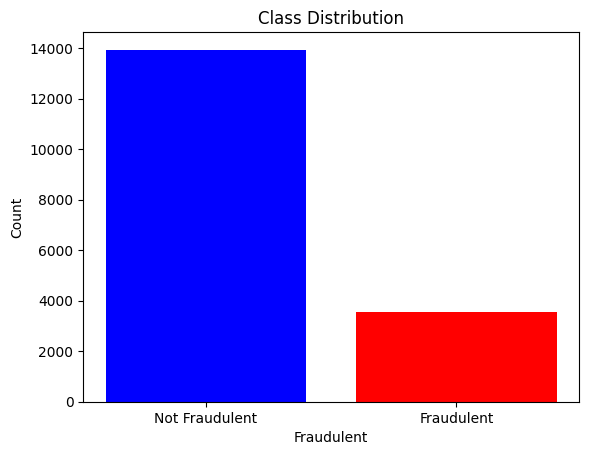

Class Distribution:
0    13932
1     3568
Name: Fraudulent, dtype: int64


In [ ]:
#check class distribution to understand the skewness in data or if the data is imbalance
# Count occurrences of each class
fraudulent_counts = df['Fraudulent'].value_counts()

# Plot class distribution
plt.bar(fraudulent_counts.index, fraudulent_counts.values, color=['blue', 'red'])
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Not Fraudulent', 'Fraudulent'])
plt.show()

print("Class Distribution:")
print(fraudulent_counts)


In [ ]:
df.columns

Index(['TransactionAmount', 'MerchantID', 'TimeOfTransaction', 'Location',
       'PreviousTransactionHistory', 'UserSpendingPatterns', 'Fraudulent',
       'CardType', 'CardIssuer', 'IsInternational', 'IsHighRiskMerchant',
       'TransactionType', 'AmountBalance', 'MerchantType', 'MerchantLocation',
       'UserAge', 'MerchantCategory', 'MerchantRevenue'],
      dtype='object')

#### feature engineering
- this step includes handling categorical features
- includes scaling of data from continuous distribution using Standardization or Normalisation


In [ ]:
# handling the categorical features
df = df.drop(["TimeOfTransaction"], axis = 1)
label_encoders = {}
categorical_columns = ['MerchantID', 'Location', 'PreviousTransactionHistory', 'UserSpendingPatterns', 'CardType',
                       'CardIssuer', 'TransactionType', 'MerchantType', 'MerchantLocation', 'MerchantCategory']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [ ]:
df.head()

,TransactionAmount,MerchantID,Location,PreviousTransactionHistory,UserSpendingPatterns,Fraudulent,CardType,CardIssuer,IsInternational,IsHighRiskMerchant,TransactionType,AmountBalance,MerchantType,MerchantLocation,UserAge,MerchantCategory,MerchantRevenue
0,7619.187028,0,0,1,1,0,0,2,0,0,5,34467.775103,2,1,32.0,0,213157.066128
1,7326.161292,1,2,0,1,0,0,1,0,0,4,11702.801310,2,0,58.0,0,406463.540738
2,1590.975602,0,1,0,0,0,1,2,0,0,5,30042.953541,1,2,37.0,1,449679.394121
3,1723.942456,1,0,1,0,0,1,1,0,0,5,14334.955692,1,0,40.0,2,363288.468427
4,4096.798986,2,1,0,1,0,1,2,0,0,4,48200.414510,2,0,38.0,0,379609.668931


In [ ]:
# train test split
X = df.drop(['Fraudulent'], axis=1)
y = df['Fraudulent']

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Create a pipeline with StandardScaler and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the test data
y_pred = pipeline.predict(X_test)
accuracy = pipeline.score(X_test, y_test)
print("Accuracy using Logistic Regression:", accuracy)

# show confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"{cm}")

Accuracy using Logistic Regression: 0.8028571428571428
[[2810    0]
 [ 690    0]]


In [ ]:
# lets use other classifiers like RandomForest to compare the accuracy
pipelines = {
    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())]),
     'Decision Tree': Pipeline([('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier())]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('classifier', SVC())])

}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = pipeline.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)

    print("\n")
    print(f"{name} Accuracy:", accuracy)
    print(f"{name} Confusion Matrix:")
    print(cm)




Logistic Regression Accuracy: 0.8028571428571428
Logistic Regression Confusion Matrix:
[[2810    0]
 [ 690    0]]


Decision Tree Accuracy: 0.6722857142857143
Decision Tree Confusion Matrix:
[[2178  632]
 [ 515  175]]


Random Forest Accuracy: 0.8025714285714286
Random Forest Confusion Matrix:
[[2809    1]
 [ 690    0]]


SVM Accuracy: 0.8028571428571428
SVM Confusion Matrix:
[[2810    0]
 [ 690    0]]
